# A data-driven investigation into DHS and FBI surveillance planes

This is a somewhat-reproduction of [Spies in the Skies: See Maps Showing Where FBI Planes Are Watching From Above](https://www.buzzfeednews.com/article/peteraldhous/spies-in-the-skies) (BuzzFeed) to teach you the joys of machine learning and feature importance.

### Install necessary software

In [ ]:
# !pip install shapely cartopy --no-binary shapely --no-binary cartopy

### Download the data that we'll need

In [1]:
# # Make data directory if it doesn't exist
# !mkdir -p data

# Download flight data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/flights_data4-1529539200-cleaned.csv.zip -P data
# !unzip -n -d data data/flights_data4-1529539200-cleaned.csv.zip

# Download plane descriptions
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/opensky-features.csv -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/planes_features.csv -P data

# Download known federally-owned planes
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/train.csv -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/feds.csv -P data

### Awful setup

In [196]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import types
import cartopy.io.img_tiles as img_tiles
import requests
import PIL
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt
import math

pd.set_option("display.max_columns", 200)

class CachedTiler(object):
    def __init__(self, tiler):
        self.tiler = tiler

    def __getattr__(self, name):
        attr = getattr(self.tiler, name, None)
        if isinstance(attr, types.MethodType):
            attr = types.MethodType(attr.__func__, self)
        return attr

    def get_image(self, tile):
        tileset_name = '{}'.format(self.tiler.__class__.__name__.lower())
        cache_dir = os.path.expanduser(os.path.join('~/', 'image_tiles', tileset_name))
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        tile_fname = os.path.join(cache_dir, '_'.join(str(v) for v in tile) + '.png')
        if not os.path.exists(tile_fname):
            response = requests.get(self._image_url(tile),
                                    stream=True)

            with open(tile_fname, "wb") as fh:
                for chunk in response:
                    fh.write(chunk)
        with open(tile_fname, 'rb') as fh:
            img = PIL.Image.open(fh)
            img = img.convert(self.desired_tile_form)     
        return img, self.tileextent(tile), 'lower'

# Initialize our Google Maps tiles
actual_tiler = cimgt.GoogleTiles()
imagery = CachedTiler(actual_tiler)

def draw_flight(ax, flight, name):
    # Set the boundaries around the map
    ax.set_extent([ 
        flight.longitude.max(), flight.longitude.min(),
        flight.latitude.min(), flight.latitude.max()
    ], crs=ccrs.Geodetic())

    # Draw the background
    ax.add_image(imagery, 9)
    ax.set_title(name)

    # Draw the path of the flight
    track = sgeom.LineString(zip(flight.longitude, flight.latitude))
    ax.add_geometries([track],
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='red',
                      linewidth=2)
    return ax

def draw_flights(readings, max_count=28):
    remaining_paths = 28

    flights = readings.groupby(['firstseen', 'icao24'])

    # 3 per row, calculate number of rows
    num_cols = 4
    num_rows = math.ceil(len(flights) / num_cols)

    # Make a 15x15 graphic
    plt.figure(figsize=(15, num_rows * num_cols), facecolor='white')

    for i, (name, flight) in enumerate(flights):
        if remaining_paths < 1:
            break
        remaining_paths -= 1

        ax = plt.subplot(num_rows, num_cols, i+1, projection=imagery.crs)
        draw_flight(ax, flight, name[1])

# PART ONE: Finding surveillance planes manually

**Read this:** [Spies in the Skies: See Maps Showing Where FBI Planes Are Watching From Above](https://www.buzzfeednews.com/article/peteraldhous/spies-in-the-skies)

Can we find our own surveillance planes?

## Read in our data

We're doing to be using **two datasets** for this.

First, we'll need all of the original flight readings. We'll take their readings for the planes we're interested in and draw lines between them, essentially recreating the flight paths. Flight data has seen a lot of use recently, namely [regarding flight paths over Russia and Ukraine](https://graphics.reuters.com/UKRAINE-CRISIS/AIRLINES/klpykbmropg/).

Flight reading data can be found at sites like the ones below. Sometimes you can get them for free by being a journalist or setting up a transponder to contribute to the system!

- https://opensky-network.org/
- https://globe.adsbexchange.com/
- https://www.flightradar24.com/

For our second dataset, we'll need descriptions of a "typical" flight for each plane - how height they usually flying, how fast they usually fly, how much they were turning, etc etc. We'll use this to find the transponder codes for interesting planes.

In [245]:
# Flight path data
transponder_df = pd.read_csv('data/flights_data4-1529539200-cleaned.csv', dtype={'icao24': 'str'})
transponder_df.head(2)

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
0,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574561,609.6,41.702100,-86.469939,88.232170
1,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574559,609.6,41.702042,-86.472140,88.253716


In [246]:
# Plane descriptions
features = pd.read_csv("data/opensky-features.csv")
features.head(2)

,icao24,altitude1,altitude2,altitude3,altitude4,altitude5,duration1,duration2,duration3,duration4,duration5,area1,area2,area3,area4,area5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,observations
0,000001,70.951157,28.149100,0.899743,0.000000,0.000000,33.333333,0.0,0.0,0.0,66.666667,100.0,0.0,0.0,0.0,0.0,1.609788,2.318094,56.213780,6.696716,3.090792,27.817128,1.094656,1.159047,1556
1,010154,2.357564,3.339882,8.447937,3.536346,82.318271,0.000000,0.0,0.0,0.0,100.000000,0.0,0.0,100.0,0.0,0.0,0.000000,0.196850,7.874016,75.590551,12.598425,3.543307,0.196850,0.000000,509


## Drawing a few flight paths

Let's grab a random five planes and draw some of their flights!

In [247]:
# Select 5 random planes
random_icao24 = transponder_df.sample(5).icao24.unique()

readings = transponder_df[transponder_df.icao24.isin(random_icao24)]
readings.head()

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
140441,a031bd,AAL706,1529539200,1.529621e+09,1529624590,NaN,KTPF,1529624589,1219.2,27.920334,-82.417153,181.278717
140442,a031bd,AAL706,1529539200,1.529621e+09,1529624590,NaN,KTPF,1529624460,1219.2,28.048553,-82.413993,181.342621
140443,a031bd,AAL706,1529539200,1.529621e+09,1529624590,NaN,KTPF,1529624430,1524.0,28.084639,-82.413133,181.282532
140444,a031bd,AAL706,1529539200,1.529621e+09,1529624590,NaN,KTPF,1529624364,1828.8,28.168716,-82.412462,182.436646
140445,a031bd,AAL706,1529539200,1.529621e+09,1529624590,NaN,KTPF,1529624353,1828.8,28.182306,-82.411517,188.639633


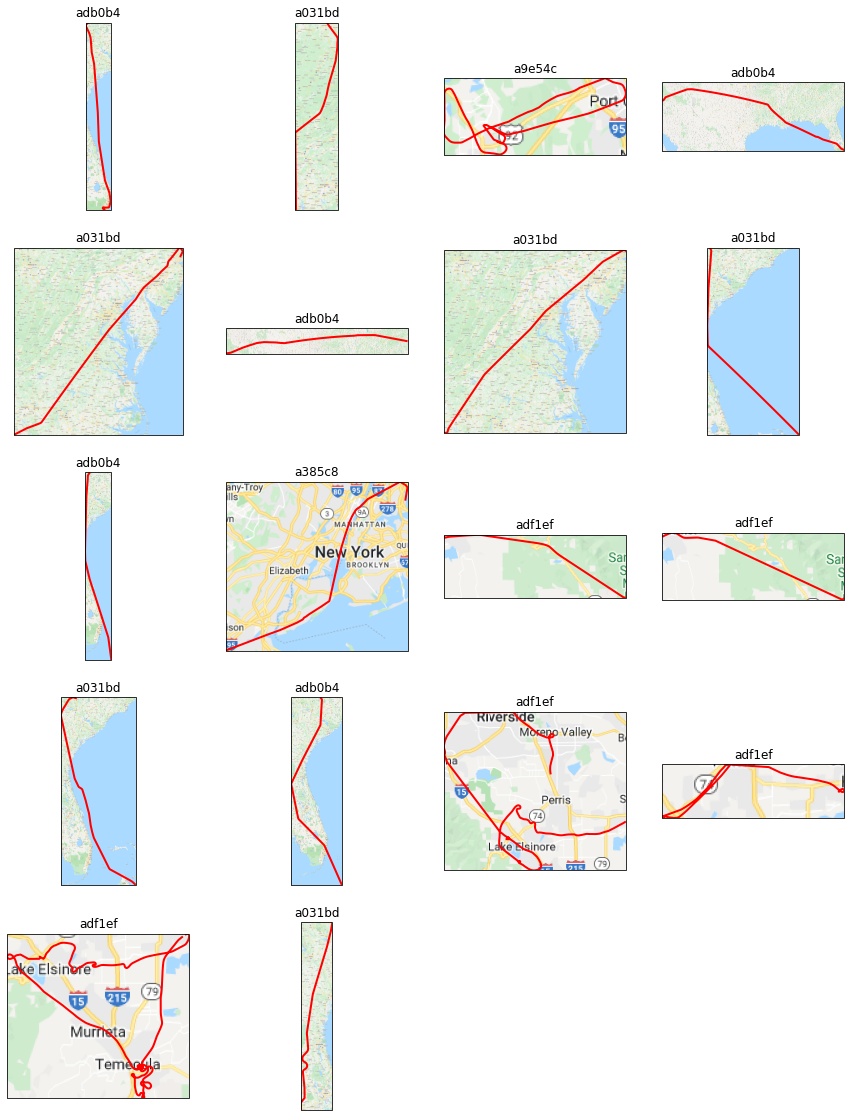

In [248]:
draw_flights(readings)

## Selecting planes to draw

That wasn't very useful! Instead, let's try to find planes that seem like they might be surveillance planes.

**Choose your own adventure:** what will you use to determine if a plane is suspicious?

In [249]:
# These planes typically stayed in a small area
suspicious = features.sort_values(by='area1', ascending=False).head(30)

# These planes typically spent time turning to one direction
# suspicious = features.sort_values(by='steer2', ascending=False).head(30)

# These planes typically flew very low
# suspicious = features.sort_values(by='altitude1', ascending=False).head(30)

To mix things up a little bit (and so we'll all have different results), we'll pick the 30 most suspicious planes, then randomly pick ten of those.

In [250]:
# Randomly select ten of the 50 most suspicious planes
suspicious_icao24 = suspicious.icao24.str.lower().sample(10)

readings = transponder_df[transponder_df.icao24.isin(suspicious_icao24)]
readings.head()

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
426405,a5414a,N438ER,1529539200,1.529618e+09,1529619896,KC29,KC29,1529619889,304.8,43.114243,-89.535764,100.007980
426406,a5414a,N438ER,1529539200,1.529618e+09,1529619896,KC29,KC29,1529619877,304.8,43.114838,-89.540363,98.004730
426407,a5414a,N438ER,1529539200,1.529618e+09,1529619896,KC29,KC29,1529619852,304.8,43.115845,-89.550214,98.004730
426408,a5414a,N438ER,1529539200,1.529618e+09,1529619896,KC29,KC29,1529619850,304.8,43.115982,-89.551221,101.309929
426409,a5414a,N438ER,1529539200,1.529618e+09,1529619896,KC29,KC29,1529619849,304.8,43.116028,-89.551477,105.037819


For each plane we have a selection of transponder readings. While all of the details are *interesting*, the important parts right now are the latitude and longitude, which we'll use to plot the flight path.

To break these into flights, we'll need to split them into groups based on the `firstseen` column, which is the first time during a given flight when the plane was noticed by a receiver.

In [251]:
len(f"Total of {len(readings.firstseen.unique())} flights")

19

## Actually drawing our flight paths

This is what we're here for, right? Let's go!

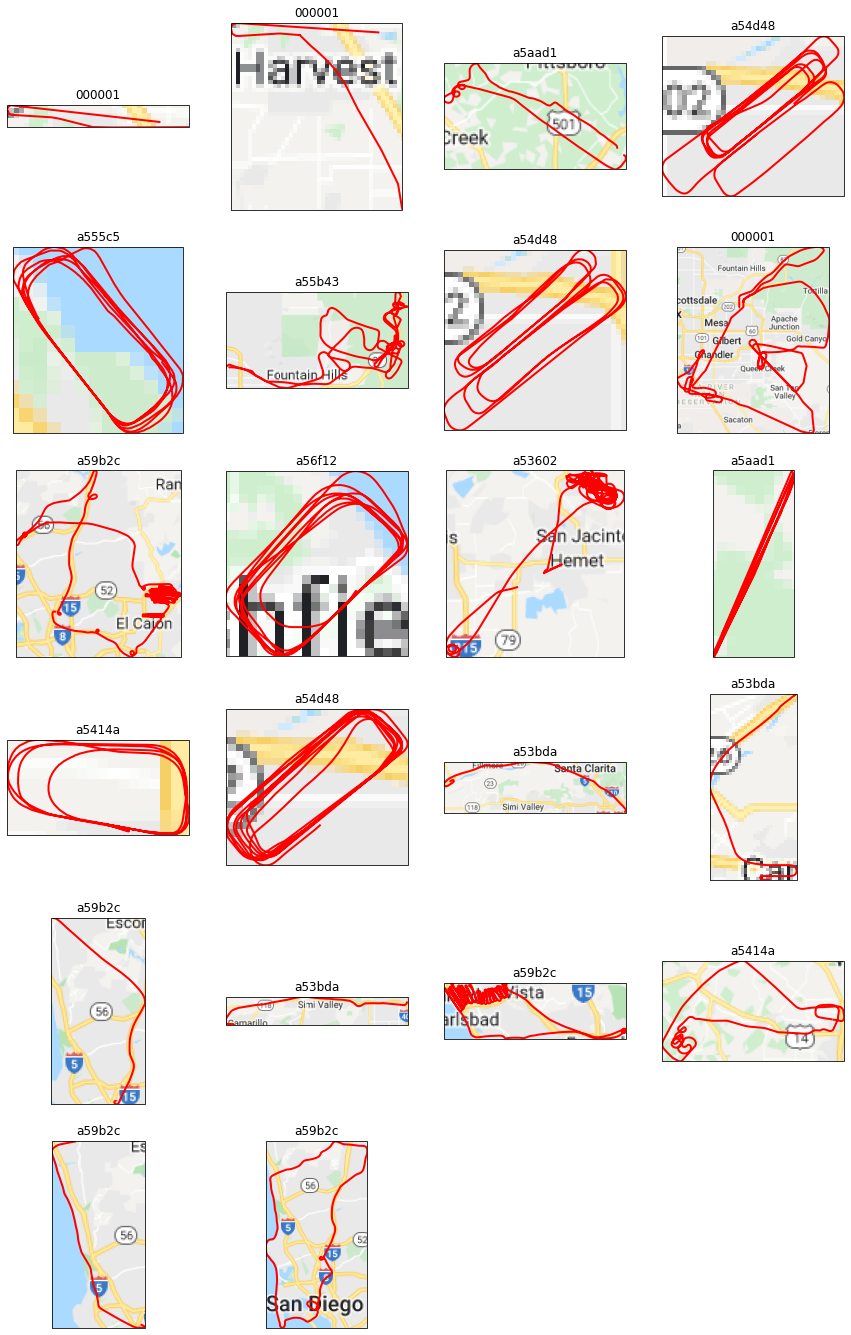

In [252]:
draw_flights(readings)

**Which ones seem worth investigating?** Why or why not?

# PART TWO: Teaching a computer to find spy planes

## Reading in our data

Now we're going to teach a computer to do the same thing we just did! Technically speaking this is called **classification** (or if you want to get extra fancy, in this case it's going to use a **logistic regression classifier**) but that's not terribly important at the moment!

We'll start with two datasets:

* A description of a typical flight for each plane
* A list of planes, each marked by whether we know it's owned by the Department of Homeland Security/FBI or not

We're going to use the planes we know about to teach the computer what a surveillance plane looks like, then unleash it on the rest of the flights!

In [286]:
# Typical flights for each plane
features = pd.read_csv("data/planes_features.csv")
features.sample(5)

,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type
14461,A9B381,0.000000,0.000000,0.333333,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.109244,0.107843,0.075630,0.099440,0.607843,0.540616,0.088235,0.067227,0.071429,0.232493,0.039216,0.078431,0.203081,0.438375,0.075630,0.117647,0.018207,0.009804,3,7464,714,unknown
19546,ADD65A,0.366667,0.166667,0.166667,0.100000,0.200000,0.366667,0.166667,0.200000,0.166667,0.100000,0.767857,0.178571,0.051948,0.000000,0.001623,0.077922,0.271104,0.438312,0.212662,0.000000,0.022727,0.027597,0.183442,0.509740,0.081169,0.121753,0.003247,0.017857,30,3644,616,P28A
6432,A3DE28,0.034483,0.137931,0.275862,0.310345,0.241379,0.206897,0.103448,0.379310,0.172414,0.137931,0.196971,0.454799,0.346836,0.001394,0.000000,0.191861,0.414568,0.313296,0.080275,0.000000,0.019790,0.034934,0.274459,0.344978,0.159900,0.148286,0.005482,0.002973,29,1200,10763,C177
8786,A559C2,0.147727,0.102273,0.215909,0.170455,0.363636,0.147727,0.034091,0.079545,0.193182,0.545455,0.009804,0.026574,0.135191,0.213880,0.614551,0.011094,0.017286,0.018576,0.039474,0.913571,0.019350,0.025026,0.223684,0.424407,0.093137,0.165635,0.007224,0.015996,88,0,3876,PAY3
9813,A639F1,0.282051,0.102564,0.051282,0.358974,0.205128,0.256410,0.102564,0.076923,0.051282,0.512821,0.195652,0.312500,0.149457,0.209239,0.133152,0.054348,0.230978,0.141304,0.259511,0.313859,0.035326,0.023098,0.186141,0.487772,0.057065,0.145380,0.008152,0.021739,39,0,736,C414


In [287]:
# List of labeled planes
labeled = pd.read_csv("data/train.csv").rename(columns={'class': 'label'})
labeled.sample(5)

,adshex,label
408,A3B185,other
419,A3A655,other
101,A1914D,other
140,A57674,other
530,ADD1C7,other


Now we'll **combine our datasets** so each plane's typical flight also details whether it's a surveillance plane or not.

In [288]:
df = labeled.merge(features, on='adshex', how='right')
df.head(2)

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type
0,A,NaN,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.02055,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND
1,A00000,NaN,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.14341,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7


How many planes do we have **in total?**

In [294]:
df.shape

(19799, 34)

How many do we have marked as to **whether they're surveillance planes or not?**

In [295]:
df.label.value_counts(dropna=False)

NaN        19202
other        500
surveil       97
Name: label, dtype: int64

Now let's get to work.

## Cleaning up our data

Computers are very picky about what they'll listen to. If we were in a class we'd spend more time on the details, but hey: we've got things to do! The general gist is that we need to convert text - like "surveil" and "other" or the type of plane – "TBM7", "C56X" – into numbers.

In [296]:
# Replace surveil/not surveil label with 1/0
df['label'] = df.label.replace({
    'surveil': 1,
    'other': 0
})

# Convert plane type into number 
df.type = df.type.astype('category')
df['type_code'] = df.type.cat.codes

df.head(2)

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type_code
0,A,NaN,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.02055,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,248
1,A00000,NaN,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.14341,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,431


## Teaching the computer, a.k.a. training a classifier

Three easy steps!

**Step one:** Select what columns we'll use to teach the computer.

In [258]:
# This removes unidentified planes
# we only want to teach on ones we *know* are DHS/FBI or not
train_df = df.dropna()

feature_cols = ['duration1', 'duration2', 'duration3', 'duration4',
    'duration5', 'boxes1', 'boxes2', 'boxes3', 'boxes4', 'boxes5', 'speed1',
    'speed2', 'speed3', 'speed4', 'speed5', 'altitude1', 'altitude2',
    'altitude3', 'altitude4', 'altitude5', 'steer1', 'steer2', 'steer3',
    'steer4', 'steer5', 'steer6', 'steer7', 'steer8', 'flights', 'squawk_1',
    'observations', 'type_code']

X = train_df[feature_cols]
y = train_df.label

> *If you want to get technical:* the information we're using to describe the planes are called **features**

**Step two:** Split our data into two groups – one for learning, one for testing the results – so we can see how well the computer learns.

In [259]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

> *If you want to get technical:* this process is called train/test split (you can probably tell since it says `train_test_split` about a hundred times)

**Step three:** Teach the computer!

In [260]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1e9, solver='lbfgs', max_iter=4000)

clf.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, max_iter=4000)

> *If you want to get technical:* this is called **training the classifier** or **fitting the model**

## Interpreting the results

We tried to teach it what a surveillance plane looks like, but did we do a good job? Just like a teacher might give you a test, we can give our classifier a test!

When we did the train/test split we saved a few planes to use as quiz material. Now we'll use those saved ones (the "test" part of the split) to see if it can figure out whether they're surveillance planes or not!

In [298]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not surveil', 'surveil'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not surveil,Predicted surveil
Is not surveil,126,3
Is surveil,6,15


What do we think? How did it do?

**What's the downside of a mistake in one direction or another?**

### What did it think was important?

When we were casting around aimlessly trying to find spy planes before, we had to pick whether we thought altitude, speed or steering were more important. Now that we've trained a classifier, we can look at the **feature importance** to see what features our classifier used to differentiate between surveillance planes and normal planes.

In [275]:
import eli5

feature_names = list(X.columns)
eli5.show_weights(clf, feature_names=feature_names)

Positive numbers mean a feature implies a surveillance plane, while negative numbers imply a non-surveillance plane.

## Finding suspicious planes

Now let's turn back to our unlabeled data. We'll point our classifier to the descriptions of the remaining planes, and it will tell us whether it thinks each plane is a surveillance plane or not!

In [276]:
# Classifier: please learn!
clf.fit(X, y)

LogisticRegression(C=1000000000.0, max_iter=4000)

In [277]:
# Pull out the unknown planes...
unknown_df = df.loc[df.label.isna()].copy()

# ... ask the classifier for its opinion...
unknown_X = unknown_df[feature_cols]
unknown_df['predicted'] = clf.predict(unknown_X)
unknown_df['predicted_prob'] = clf.predict_proba(unknown_X)[:,1]

## ...and look at the results
unknown_df.head()

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type_code,predicted,predicted_prob
0,A,NaN,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,0.021824,0.020550,0.062330,0.100713,0.794582,0.042374,0.060971,0.066831,0.106403,0.723421,0.020211,0.048913,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,GRND,248,0.0,0.002370
1,A00000,NaN,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,0.107348,0.143410,0.208139,0.177013,0.364090,0.177318,0.114457,0.129648,0.197694,0.380882,0.034976,0.048127,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,TBM7,431,0.0,0.011648
3,A00008,NaN,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,0.187960,0.278952,0.221048,0.190257,0.121783,0.014706,0.053309,0.149816,0.279871,0.502298,0.029871,0.044118,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,PA46,350,0.0,0.007985
4,A0001E,NaN,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,0.007937,0.026984,0.084127,0.179365,0.701587,0.041270,0.085714,0.039683,0.111111,0.722222,0.019048,0.049206,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,C56X,126,0.0,0.006192
5,A0002B,NaN,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.767405,0.191456,0.023734,0.017405,0.000000,0.150316,0.113924,0.178797,0.534810,0.022152,0.001582,0.009494,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,C82S,133,0.0,0.131772


We added two new columns: `predicted` and `predicted_proba`.

* `predicted` is a yes/no as to whether it thinks something is a surveillance plane or not
* `predicted_proba` is a numeric score - a higher value means it's more likely to be a surveillance plane

**How many did it predict to be a surveillance plane?**

In [280]:
unknown_df.predicted.value_counts()

0.0    18716
1.0      486
Name: predicted, dtype: int64

### We could grab all of the predicted YES planes...

In [300]:
unknown_df[unknown_df.predicted == 1].head(10)

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type_code,predicted,predicted_prob
25,A001FC,NaN,0.222222,0.222222,0.222222,0.111111,0.222222,0.222222,0.222222,0.111111,0.222222,0.222222,0.132623,0.261375,0.230397,0.305905,0.069700,0.128751,0.324298,0.069700,0.310745,0.166505,0.097773,0.055179,0.268151,0.292352,0.090029,0.141336,0.011617,0.013553,9,7754,1033,BE35,53,1.0,0.784271
41,A00324,NaN,0.000000,0.000000,0.000000,0.235294,0.764706,0.000000,0.735294,0.176471,0.029412,0.058824,0.051807,0.451666,0.410089,0.086157,0.000282,0.081605,0.067949,0.180807,0.632520,0.037119,0.075598,0.181276,0.373111,0.130127,0.091131,0.120319,0.004270,0.002393,34,5347,21310,C208,97,1.0,0.662624
270,A01AD0,NaN,0.432432,0.135135,0.135135,0.243243,0.054054,0.135135,0.405405,0.108108,0.162162,0.189189,0.074670,0.296381,0.177484,0.164273,0.287191,0.008041,0.031591,0.078690,0.376795,0.504882,0.028145,0.035037,0.197588,0.476738,0.079839,0.144170,0.009765,0.011488,37,7240,1741,COL4,148,1.0,0.638335
304,A01E2A,NaN,0.238095,0.047619,0.523810,0.047619,0.142857,0.190476,0.047619,0.476190,0.142857,0.142857,0.185384,0.174100,0.376142,0.128963,0.135411,0.069318,0.152069,0.335304,0.163353,0.279957,0.036002,0.052660,0.257926,0.281032,0.090811,0.203654,0.020419,0.018807,21,7625,1861,P32R,330,1.0,0.800517
328,A021F4,NaN,0.200000,0.400000,0.100000,0.300000,0.000000,0.200000,0.400000,0.200000,0.200000,0.000000,0.397869,0.520426,0.081705,0.000000,0.000000,0.019538,0.241563,0.264654,0.197158,0.277087,0.017762,0.021314,0.316163,0.289520,0.104796,0.225577,0.000000,0.012433,10,4640,563,unknown,454,1.0,0.543688
443,A02F3D,NaN,0.307692,0.384615,0.230769,0.076923,0.000000,0.384615,0.230769,0.384615,0.000000,0.000000,0.391017,0.375165,0.192867,0.036988,0.003963,0.006605,0.233818,0.368560,0.391017,0.000000,0.021136,0.038309,0.270806,0.363276,0.054161,0.203435,0.009247,0.018494,13,4774,757,C177,89,1.0,0.629825
554,A0373B,NaN,0.241935,0.241935,0.064516,0.370968,0.080645,0.209677,0.209677,0.112903,0.193548,0.274194,0.255569,0.333107,0.234654,0.146234,0.030437,0.103554,0.077538,0.167489,0.291107,0.360313,0.015644,0.033498,0.305730,0.281075,0.102704,0.228192,0.012413,0.011563,62,7457,5881,C208,97,1.0,0.749863
589,A03A52,NaN,0.078947,0.526316,0.263158,0.078947,0.052632,0.105263,0.078947,0.552632,0.236842,0.026316,0.023438,0.116943,0.586336,0.256202,0.017080,0.134148,0.364543,0.232390,0.268919,0.000000,0.004738,0.006732,0.202843,0.577359,0.139384,0.061090,0.003241,0.001496,38,7124,8021,BE36,54,1.0,0.644014
602,A03B53,NaN,0.111111,0.444444,0.222222,0.000000,0.222222,0.111111,0.444444,0.000000,0.444444,0.000000,0.831432,0.159696,0.006337,0.001267,0.001267,0.002535,0.039290,0.487959,0.470215,0.000000,0.006337,0.020279,0.262357,0.419518,0.117871,0.153359,0.003802,0.007605,9,4565,789,unknown,454,1.0,0.661288
606,A03BAC,NaN,0.136364,0.181818,0.227273,0.136364,0.318182,0.181818,0.227273,0.409091,0.090909,0.090909,0.074543,0.256740,0.661480,0.007237,0.000000,0.167360,0.122128,0.227791,0.127917,0.354804,0.013932,0.017007,0.359689,0.224353,0.153971,0.208612,0.006333,0.006333,22,7750,5527,AC11,6,1.0,0.802580


### ...but maybe we'll just get the top 200 predictions?

Instead of just looking at the surveillance predictions, we can instead look at the top 200 planes that are **most likely to be surveillance planes.**

We'll then save them to a file for later research.

In [301]:
top_predictions = unknown_df.sort_values(by='predicted_prob', ascending=False).head(200)
top_predictions.head(10)

,adshex,label,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,speed1,speed2,speed3,speed4,speed5,altitude1,altitude2,altitude3,altitude4,altitude5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type,type_code,predicted,predicted_prob
5042,A2F7D7,NaN,0.307692,0.307692,0.153846,0.153846,0.076923,0.384615,0.230769,0.153846,0.153846,0.076923,0.847262,0.074928,0.043228,0.008646,0.025937,0.051873,0.280980,0.468300,0.198847,0.000000,0.014409,0.038905,0.256484,0.376081,0.102305,0.188761,0.007205,0.007205,13,7176,694,C172,88,1.0,0.919064
3112,A1B621,NaN,0.615385,0.076923,0.153846,0.000000,0.153846,0.538462,0.307692,0.076923,0.076923,0.000000,0.524156,0.331568,0.103243,0.039709,0.001324,0.053607,0.080079,0.756453,0.105228,0.004633,0.455328,0.173395,0.138981,0.052945,0.021840,0.049636,0.001985,0.008604,13,5240,1511,C210,98,1.0,0.912979
9889,A63E52,NaN,0.333333,0.196078,0.137255,0.078431,0.254902,0.549020,0.313725,0.137255,0.000000,0.000000,0.817386,0.122310,0.051307,0.005714,0.003283,0.077204,0.297143,0.622492,0.003161,0.000000,0.207295,0.219210,0.251185,0.125471,0.028571,0.075137,0.009848,0.019574,51,5306,8225,T206,417,1.0,0.912836
13210,A8BB0C,NaN,0.166667,0.083333,0.250000,0.333333,0.166667,0.166667,0.250000,0.000000,0.416667,0.166667,0.450766,0.347192,0.178702,0.008023,0.015317,0.004376,0.088257,0.800146,0.107221,0.000000,0.020423,0.029905,0.256018,0.346462,0.074398,0.237783,0.012400,0.004376,12,7742,1371,P28A,323,1.0,0.908686
2922,A19C0B,NaN,0.100000,0.350000,0.300000,0.100000,0.150000,0.100000,0.400000,0.300000,0.050000,0.150000,0.723587,0.276413,0.000000,0.000000,0.000000,0.050200,0.296996,0.270111,0.382693,0.000000,0.004411,0.015543,0.340895,0.235665,0.178954,0.215081,0.001890,0.001260,20,7356,4761,C172,88,1.0,0.907052
19583,ADE07E,NaN,0.500000,0.000000,0.000000,0.250000,0.250000,0.500000,0.500000,0.000000,0.000000,0.000000,0.979048,0.017143,0.001905,0.001905,0.000000,0.201905,0.266667,0.531429,0.000000,0.000000,0.081905,0.228571,0.266667,0.251429,0.036190,0.083810,0.003810,0.015238,4,5370,525,unknown,454,1.0,0.905924
18066,ACA1BD,NaN,0.400000,0.300000,0.100000,0.000000,0.200000,0.500000,0.200000,0.100000,0.000000,0.200000,0.825077,0.091331,0.046440,0.035604,0.001548,0.086687,0.080495,0.029412,0.496904,0.306502,0.007740,0.013932,0.239938,0.439628,0.157895,0.126935,0.001548,0.003096,10,7436,646,unknown,454,1.0,0.902803
10638,A6B755,NaN,0.500000,0.321429,0.035714,0.107143,0.035714,0.392857,0.357143,0.071429,0.142857,0.035714,0.474973,0.352503,0.120341,0.008520,0.043663,0.112886,0.445154,0.227902,0.088392,0.125666,0.036209,0.038339,0.223642,0.379127,0.076677,0.174654,0.008520,0.033014,28,7363,939,C172,88,1.0,0.902147
19645,ADF1ED,NaN,0.357143,0.428571,0.071429,0.071429,0.071429,0.571429,0.285714,0.071429,0.000000,0.071429,0.485030,0.158683,0.279940,0.032934,0.043413,0.223054,0.338323,0.083832,0.121257,0.233533,0.061377,0.074850,0.224551,0.236527,0.079341,0.258982,0.020958,0.007485,14,7312,668,C82S,133,1.0,0.898591
8566,A540CE,NaN,0.363636,0.363636,0.090909,0.090909,0.090909,0.363636,0.363636,0.090909,0.090909,0.090909,0.476965,0.215447,0.258808,0.033875,0.014905,0.069106,0.426829,0.052846,0.208672,0.242547,0.029810,0.051491,0.266938,0.219512,0.098916,0.264228,0.029810,0.018970,11,7341,738,unknown,454,1.0,0.897918


In [283]:
# Save them to a file
top_predictions.to_csv("planes-to-research.csv", index=False)

## How were the results?

Let's take a look by mapping the flight paths.

In [269]:
# Randomly select ten of the 50 most suspicious planes
suspicious_icao24 = top_predictions.adshex.str.lower()

readings = transponder_df[transponder_df.icao24.isin(suspicious_icao24)]
readings.head()

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
261900,ab9eac,N848MH,1529539200,1.529623e+09,1529623953,NaN,KLAS,1529623952,609.6,36.078598,-115.171337,204.443954
261901,ab9eac,N848MH,1529539200,1.529623e+09,1529623953,NaN,KLAS,1529623944,609.6,36.079055,-115.171022,203.198593
261902,ab9eac,N848MH,1529539200,1.529623e+09,1529623953,NaN,KLAS,1529623915,609.6,36.081290,-115.169736,205.201126
261903,ab9eac,N848MH,1529539200,1.529623e+09,1529623953,NaN,KLAS,1529623910,609.6,36.081662,-115.169561,206.565048
261904,ab9eac,N848MH,1529539200,1.529623e+09,1529623953,NaN,KLAS,1529623908,609.6,36.081848,-115.169449,208.072495


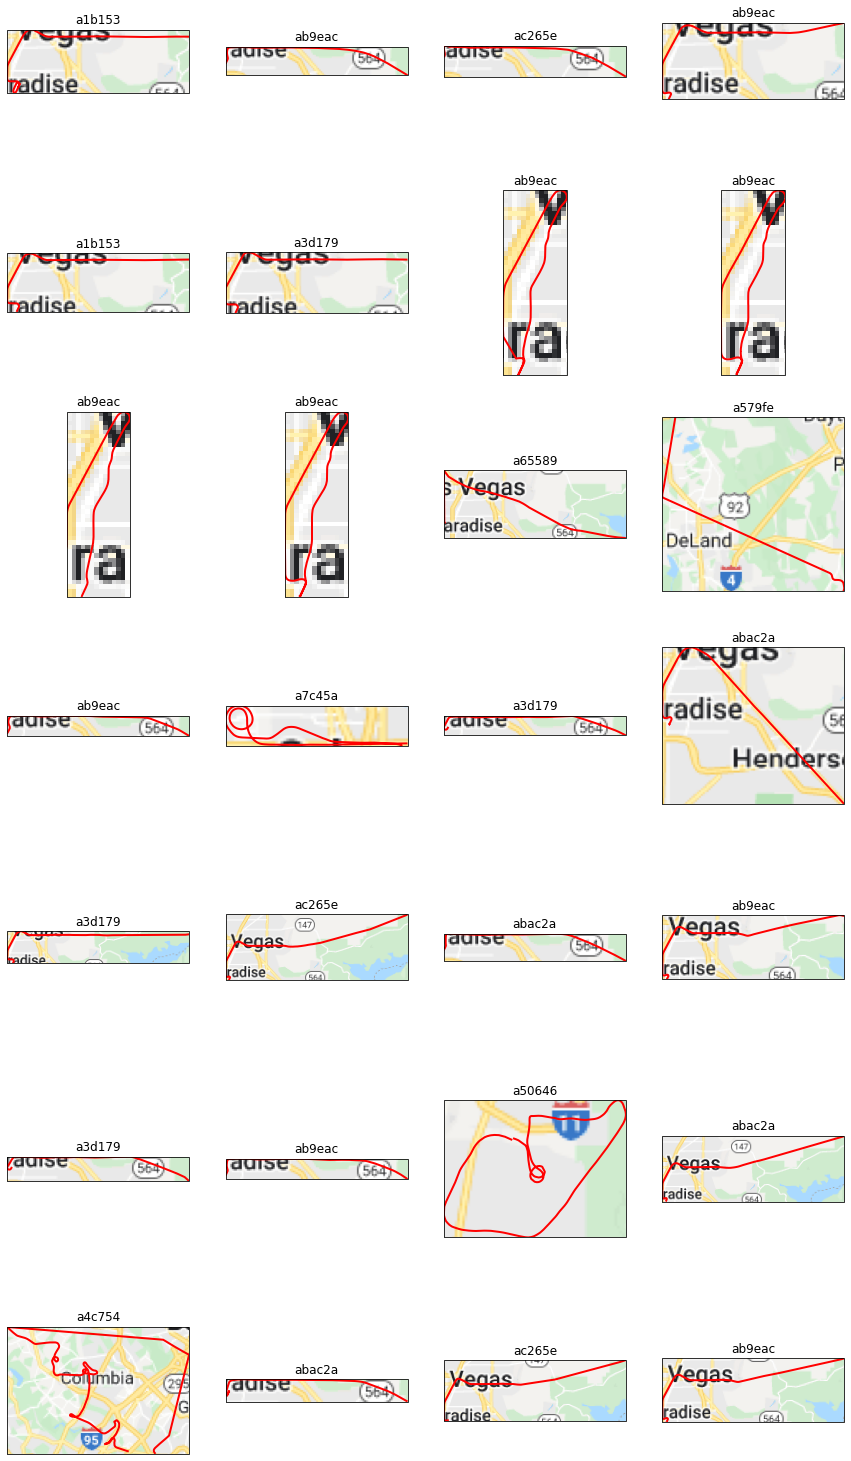

In [302]:
# Spoiler alert: it's disappointing!
# That's just a problem with the data, though.
draw_flights(readings)

## So that's classification!

**What can you use a classifier for?** Any sort of yes/no situation! You label a few examples, feed them to a computer, then ask it to label a pile of other examples.

For example:

- Whether a review of an app mentions unwanted sexual behavior: [Apple says its App Store is ‘a safe and trusted place.’ We found 1,500 reports of unwanted sexual behavior on six apps, some targeting minors.](https://www.washingtonpost.com/technology/2019/11/22/apple-says-its-app-store-is-safe-trusted-place-we-found-reports-unwanted-sexual-behavior-six-apps-some-targeting-minors/) (WaPo)
- Whether a violent crime should be a "minor offense:" [Times Investigation: LAPD misclassified nearly 1,200 violent crimes as minor offenses](https://www.latimes.com/local/la-me-crimestats-lapd-20140810-story.html) (LA Times)
- Whether a disciplinary document is about sexual misconduct [Doctors and Sex Abuse](https://doctors.ajc.com/) (AJC)

While we used logistic regression, [other classification methods often work better](https://investigate.ai/buzzfeed-spy-planes/buzzfeed-surveillance-planes-random-forests/). So why'd we pick logistic regression? *Well...*

# Side quest: Odds and odds ratios

But wait: there's more! Remember the "feature importance" detail?

In [285]:
feature_names = list(X.columns)

eli5.show_weights(clf, feature_names=feature_names)

When we use logistic regression to build a classifier, these numbers have special meaning. Instead of using our system to make predictions about unlabeled things (e.g. unknown planes), we can instead focus on feature importance. What does our algorithm learn is important when making a decision? **This is useful to help uncover bias.**

For example, we could feed a computer a bushel of information about mortgages. An applicant's age, race, income, and various other items, along with whether they were approved or denied the mortgage. Based on this information, we can ask questions like "how important is race in this decision?"

In fact, Reveal did just that in [Kept Out: for people of color, banks are shutting the door to homeownership](https://revealnews.org/article/for-people-of-color-banks-are-shutting-the-door-to-homeownership/). In this piece you see sentences like "even when controlling for applicants’ income, loan amount and neighborhood...Reveal found African Americans were 2.7 times as likely as whites to be denied a conventional mortgage." With a tiny bit more statistical knowledge, that's feature importance at work.

It's incredibly useful in investigative pieces on bias, typically with race but every now and again with other topics. Here are some other examples:

* How nationality and specific judges affect your chances of being granted asylum [They fled danger at home to make a high-stakes bet on U.S. immigration courts](https://www.reuters.com/investigates/special-report/usa-immigration-asylum/) (Reuters)
* The role of race in jury selection [How did Curtis Flowers end up with a nearly all-white jury?](https://features.apmreports.org/in-the-dark/curtis-flowers-trial-six-jury-selection/) (APM Reports)
* Demographic factors in speeding tickets vs warnings [Race, sex, and age drive ticketing](http://archive.boston.com/globe/metro/packages/tickets/072003.shtml) (Boston Globe)

# Discussion questions

### Why don't we just look at pictures of planes?

It's easy to tell visually when a plane is circling a location, so what's stopping us from just going through them all?

### Are there any other ways to narrow down the potential candidates for surveillance planes?

Think about when and where they might be used.

### Why did we use probability instead of just looking for planes with a predicted value of 1?

It seems like we should have just trusted the algorithm, right?

### How do we know whether our classifier is doing a good job or not?

Is that a reasonable approach?


### What if our classifier or input dataset were flawed? What would be the repercussions?
    
What about for the WaPo investigation into app reviews? What about for Reveal's investigation into mortgage lending?

### Let's say the time of the day for the flights was a really good predictor of whether a plane was meant for surveillance or not.

Unlike speed or altitude, though, we can't figure out *why* that would make sense. Should we still use it in our classifier?

### Read [Lunchtime Leniency: Judges' Rulings Are Harsher When They Are Hungrier](https://www.scientificamerican.com/article/lunchtime-leniency/) and be shocked! Horrified!

Then try to figure out a reason why this might not be accurate. Once you've brainstormed a bit, [go read the rebuttal](https://www.pnas.org/doi/full/10.1073/pnas.1110910108)!